Looking for the most likely cause of the decrease in Nea. % over the last 10 thousand years.

This is the time period for which we have 6 higher coverage EMHs, all from around 8 kya.

Main idea - if we restrict to super-neutral sites and we see shift in the distribution of Nea. allele frequencies, this is an evidence of migration.

If we see a significant shift at non-neutral sites *beyond* of what is observed on the super-neutral sites, this can be interpreted as selection.

*Why would this work?* After > 40k years after introgression, the individual blocks should be broken down enough so that we can stop worrying about linkage so much. We can therefore have a better idea of which SNPs are super-neutral, compared to early EMHs where, due to longer haplotypes, filtering for superneutral SNPs is problematic (i.e. how far from the informative site we want to filter potential conserved regions?)

**TODO:** Calculate the expected length of Nea. haplotype over time to justify this. (_"One of the issues with modelling selection against Nea. alleles is the fact that at the time of introgression they introgressed on shared haplotypes. Therefore, the process of selection against Nea. alleles cannot be modeled under an assumption of independent sites, for example using a diffusion approximation method. Moreover, as the length of Nea. haplotypes decays over time, the linkage between these alleles is decreasing, until, at some point, each Nea. haplotype carries approximately only single allele. To circumvent the issue, we focused on samples younger than ~8kya, which is the time point at which it is reasonable to assume that most of the Nea. deleterious alleles are segregating independently of each other."_)

**TODO**: Would it make sense to use the BAM files of the later EMHs and aggregate all the available reads to have a better idea of the actual Nea. introgressed allele frequencies or would it be too much effort?

**TODO**: Make sure to use only sites for which you have sites available from all later EMHs?

In [1]:
suppressPackageStartupMessages({
    library(tidyverse);
    library(stringr);
    library(magrittr);
    library(modelr);
    library(broom);
    library(purrr)
})

source("../R/utils.R")

In [2]:
files <- list.files("../clean_data/annotations/", pattern="priPhCons__100000bp.bed", full.names=TRUE)

window_avgs_long <- lapply(files, function(f) {
    read.table(f, header=FALSE) %>%
        .[1:4] %>%
        setNames(c("chrom", "start", "end", "value")) %>%
        mutate(track=str_replace(basename(f), ".bed", ""))
}) %>%
    bind_rows %>%
    rename(pos=end) %>% 
    select(-start)

window_avgs_wide <- spread(window_avgs_long, track, value)

In [3]:
suppressMessages(
    cadd_wide <-
        load_annotations("../clean_data/annotations.tsv") %>%
        select(chrom, pos, bStatistic, Consequence, AnnoType)
)

Warning message:
“673 parsing failures.
row # A tibble: 5 x 4 col     row            col               expected  actual expected   <int>          <chr>                  <chr>   <chr> actual 1  2136 mapAbility35bp no trailing characters      .5 row 2  4607 mapAbility35bp no trailing characters .333333 col 3  5028 mapAbility35bp no trailing characters      .5 expected 4  5379 mapAbility35bp no trailing characters      .5 actual 5  5819 mapAbility35bp no trailing characters      .5
... ................. ... ..................................................... ........ ..................................................... ...... ..................................................... ... ..................................................... ... ..................................................... ........ ..................................................... ...... .....................................................
See problems(...) for more details.
”

In [4]:
all_annots_wide <- inner_join(window_avgs_wide, cadd_wide)

Joining, by = c("chrom", "pos")


In [5]:
colnames(all_annots_wide)[3:ncol(all_annots_wide)]

[1] "priPhCons__100000bp" "bStatistic"          "Consequence"        
[4] "AnnoType"

In [6]:
table(all_annots_wide$AnnoType)


   CodingTranscript          Intergenic NonCodingTranscript   RegulatoryFeature 
               8275              440179                8398              100604 
         Transcript 
             387901 

In [7]:
# read processed SNP tables of aDNA samples and SGDP individuals,
# merge them and intersect them with the annotations data
all_snps <- load_dataset("../clean_data/ice_age.tsv",
                         "../clean_data/sgdp.tsv",
                         "../clean_data/archaics.tsv",
                         filter_damage=FALSE,
                         metadata_path="../raw_data/10_24_2014_SGDP_metainformation_update.txt",
                         random_sample=T)

emh_info <- # filter out high C-T samples (mainly non-UDG treated ones and weird library preps)
  read_delim("../clean_data/ages.txt", delim=" ") %>%
  mutate(pop="EMH_Europe") %>%
  filter(name %in% colnames(all_snps),
         ! name %in% c("AfontovaGora3", "GoyetQ116_1", "Kotias", "Oase1", "Satsurblia", "Villabruna")) %>%
  filter(age < 10000)
  

# process the SGDP metainformation table
sgdp_info <-
  load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
  mutate(name=str_replace(name, "^S_", "")) %>%
  filter(name %in% colnames(all_snps)) %>%
  mutate(age=0) %>%
  rename(pop=Region) %>%
  filter(pop == "WestEurasia") %>%
  mutate(pop="present_Europe") %>% 
  filter(! Country %in% c('Iran', 'Iraq', 'Jordan', 'Israel(Central)',
                          'Israel(Carmel)', 'Israel(Negev)', 'Israel', 'Tajikistan', 'Turkey', 'Yemen',
                          'Abkhazia', 'Armenia')) %>% 
  sample_n(size=nrow(emh_info))

samples_info <-
  bind_rows(emh_info, sgdp_info) %>%
  mutate(post_admixture=55000 - age)

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”Parsed with column specification:
cols(
  .default = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  Coverage = col_integer(),
  HetRateAuto = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Warning message:
“Unknown variables: `S_Australian_1`, `S_Australian_5`”Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character(),
  Altai = col_integer(),


In [8]:
nrow(all_snps)

[1] 484016

In [9]:
samples_info %>% group_by(pop) %>% count()

pop,n
EMH_Europe,6
present_Europe,6


In [10]:
select(filter(samples_info, pop == "EMH_Europe"), name, age, pop)

name,age,pop
Karelia,8375,EMH_Europe
Loschbour,8050,EMH_Europe
LaBrana1,7815,EMH_Europe
Hungarian_KO1,7660,EMH_Europe
Motala12,7625,EMH_Europe
Stuttgart,7140,EMH_Europe


In [11]:
select(filter(samples_info, pop == "present_Europe"), name, age, pop, Country)$name

[1] "Greek_2"     "Finnish_2"   "Abkhasian_2" "Georgian_2"  "Adygei_2"   
[6] "Orcadian_1"

Filter SNPs for early/present-day  European samples only:

In [12]:
eur_snps <- select(all_snps, c(chrom, pos, one_of(as.character(samples_info$name))))

In [13]:
head(eur_snps)

chrom,pos,Karelia,Loschbour,LaBrana1,Hungarian_KO1,Motala12,Stuttgart,Greek_2,Finnish_2,Abkhasian_2,Georgian_2,Adygei_2,Orcadian_1
1,847983,0,0,0,0,0,0,0,0,0,0,0,0
1,853089,0,0,0,NA,0,0,0,0,0,0,0,0
1,853596,NA,0,0,NA,NA,0,0,0,0,0,0,0
1,854793,0,0,0,NA,0,0,0,0,0,0,0,0
1,867552,0,0,0,NA,0,0,0,0,0,0,0,0
1,871401,NA,0,0,NA,0,0,0,0,0,0,0,0


#### What are the counts of missing sites in the EMH data?

In [14]:
select(eur_snps, Karelia:Stuttgart) %>% apply(1, function(r) sum(is.na(r))) %>% as.vector %>% table

.
     0      1      2      3      4      5      6 
155614 200980  95373  25168   4010    428   2443 

#### What is the missing SNP rate in the individual samples?

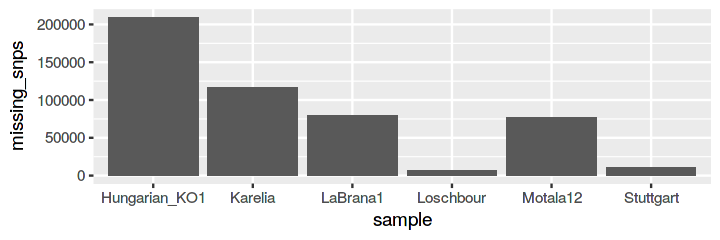

In [15]:
options(repr.plot.width=6, repr.plot.height=2)

select(eur_snps, Karelia:Stuttgart) %>%
summarise_all(function(i) sum(is.na(i))) %>%
gather(sample, missing_snps) %>% 
ggplot(aes(sample, missing_snps)) + geom_bar(stat="identity")

#### What are the counts of missing sites in the present-day data?

In [16]:
select(eur_snps, 9:ncol(eur_snps)) %>% apply(1, function(r) sum(is.na(r))) %>% table

.
     0      1      2      3      4      5      6 
483449    341    116     58     31     15      6 

#### Filter for sites with information from all individuals

In [17]:
emh_na_counts     <- select(eur_snps, Karelia:Stuttgart)    %>% apply(1, function(r) sum(is.na(r)))
present_na_counts <- select(eur_snps, 9:ncol(eur_snps)) %>% apply(1, function(r) sum(is.na(r)))

In [18]:
eur_snps <- filter(eur_snps, emh_na_counts == 0 & present_na_counts == 0)

In [19]:
nrow(eur_snps) 

[1] 155572

Create a lookup table of sample population assignments:

In [20]:
pop_table <- samples_info$pop
names(pop_table) <- samples_info$name

Merge annotations with SNP data and convert the DF into a long format:

In [21]:
merged <-
    inner_join(all_annots_wide, eur_snps) %>% # merge annotations with SNP data
    mutate(chrom=paste0(chrom, "_", pos)) %>% # create a SNP ID string
    rename(site_id=chrom) %>%  select(-pos)   # remove the chrom/pos columns

Joining, by = c("chrom", "pos")


In [23]:
head(merged)

site_id,priPhCons__100000bp,bStatistic,Consequence,AnnoType,Karelia,Loschbour,LaBrana1,Hungarian_KO1,Motala12,Stuttgart,Greek_2,Finnish_2,Abkhasian_2,Georgian_2,Adygei_2,Orcadian_1
1_847983,0.047667,958,NONCODING_CHANGE,NonCodingTranscript,0,0,0,0,0,0,0,0,0,0,0,0
1_1131600,0.031456,873,INTRONIC,Transcript,0,0,0,0,0,0,0,0,0,0,0,0
1_1193746,0.040323,769,REGULATORY,RegulatoryFeature,0,0,0,0,0,0,0,0,0,0,0,0
1_1195565,0.040551,779,REGULATORY,RegulatoryFeature,0,0,0,0,0,0,0,0,0,0,0,0
1_1200468,0.045850,784,REGULATORY,RegulatoryFeature,0,0,0,0,0,0,0,0,0,0,0,0
1_1696390,0.055556,662,INTRONIC,Transcript,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
sites <-
    gather(merged, name, allele, -site_id, -AnnoType, -Consequence, -priPhCons__100000bp, -bStatistic) %>%
    mutate(pop=pop_table[name],
           allele=ifelse(allele == 2, 1, 0))
           #allele=ifelse(allele == 0, 0, ifelse(allele == 1, 0.5, ifelse(allele == 2, 1, NA))))

In [26]:
head(sites)

site_id,priPhCons__100000bp,bStatistic,Consequence,AnnoType,name,allele,pop
1_847983,0.047667,958,NONCODING_CHANGE,NonCodingTranscript,Karelia,0,EMH_Europe
1_1131600,0.031456,873,INTRONIC,Transcript,Karelia,0,EMH_Europe
1_1193746,0.040323,769,REGULATORY,RegulatoryFeature,Karelia,0,EMH_Europe
1_1195565,0.040551,779,REGULATORY,RegulatoryFeature,Karelia,0,EMH_Europe
1_1200468,0.045850,784,REGULATORY,RegulatoryFeature,Karelia,0,EMH_Europe
1_1696390,0.055556,662,INTRONIC,Transcript,Karelia,0,EMH_Europe


In [27]:
str(sites)

'data.frame':	1866864 obs. of  8 variables:
 $ site_id            : chr  "1_847983" "1_1131600" "1_1193746" "1_1195565" ...
 $ priPhCons__100000bp: num  0.0477 0.0315 0.0403 0.0406 0.0459 ...
 $ bStatistic         : int  958 873 769 779 784 662 653 682 716 774 ...
 $ Consequence        : chr  "NONCODING_CHANGE" "INTRONIC" "REGULATORY" "REGULATORY" ...
 $ AnnoType           : chr  "NonCodingTranscript" "Transcript" "RegulatoryFeature" "RegulatoryFeature" ...
 $ name               : chr  "Karelia" "Karelia" "Karelia" "Karelia" ...
 $ allele             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ pop                : Named chr  "EMH_Europe" "EMH_Europe" "EMH_Europe" "EMH_Europe" ...
  ..- attr(*, "names")= chr  "Karelia" "Karelia" "Karelia" "Karelia" ...


Calculate the SFS of introgressed alleles at each available time point

In [28]:
sfs <- group_by(sites, pop, site_id, AnnoType, priPhCons__100000bp, bStatistic) %>%
    summarise(f=mean(allele, na.rm=TRUE)) %>% 
    #summarise(f=mean(0.5 * allele)) %>% -- this is for the case of 0/1/2 alleles
    #summarise(f=mean(allele), na.rm=TRUE) %>% -- not necessary after filtering out NA before, also no random calls
    # filter(!is.nan(f)) %>% -- not necessary either
    ungroup

In [29]:
head(sfs)

pop,site_id,AnnoType,priPhCons__100000bp,bStatistic,f
EMH_Europe,1_100002713,Intergenic,0.112185,815,0.0000000
EMH_Europe,1_100030862,Intergenic,0.120319,857,0.1666667
EMH_Europe,1_100075381,Intergenic,0.129699,813,0.0000000
EMH_Europe,1_100101335,Intergenic,0.135984,757,0.0000000
EMH_Europe,1_100102248,Intergenic,0.136405,753,0.0000000
EMH_Europe,1_100105433,Intergenic,0.141346,759,0.0000000


# Results using just the overlapping sites

In [30]:
options(repr.plot.widht=6, repr.plot.height=4)

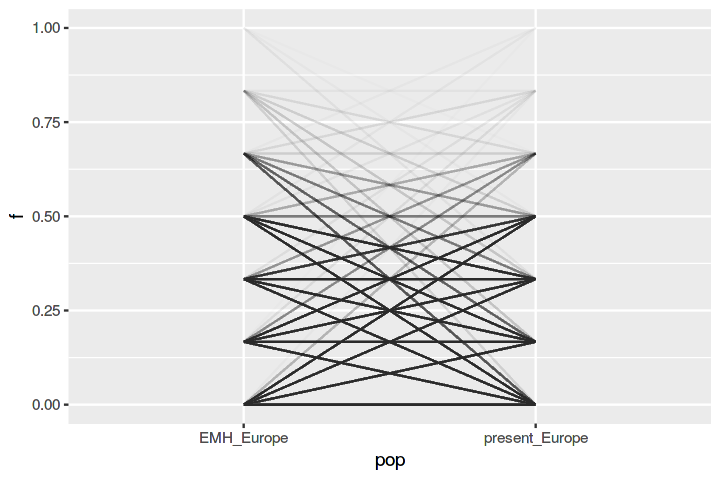

In [31]:
ggplot(sfs, aes(pop, f, group=site_id)) + geom_line(alpha=0.01) + ylim(0, 1)

Mean of the SFS of Nea. alleles in both populations:

In [32]:
group_by(sfs, pop) %>% summarise(mean(f, na.rm=TRUE))

pop,"mean(f, na.rm = TRUE)"
EMH_Europe,0.02174342
present_Europe,0.01776241


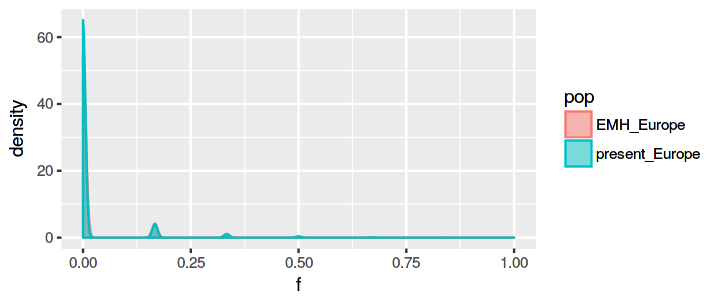

In [33]:
options(repr.plot.widht=8, repr.plot.height=2.5)
ggplot(sfs, aes(f, fill=pop, color=pop)) + geom_density(alpha=1/2) + xlim(0, 1)

Calculate the shift in Nea. allele frequencies between EMH and present-day Europeans:

In [34]:
sfs_shift <-
    spread(sfs, pop, f) %>%
    mutate(freq_shift=present_Europe - EMH_Europe)

## Genome annotation - coding/regulatory/intergenic

In [35]:
options(repr.plot.width=7, repr.plot.height=4)

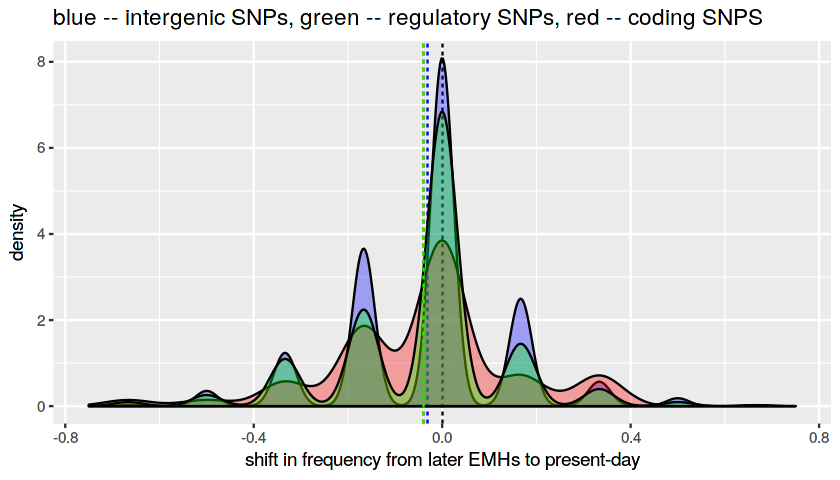

In [36]:
seg_in_emh <- filter(sfs_shift, EMH_Europe > 0, EMH_Europe < 1, present_Europe > 0, present_Europe < 1)

ggplot() +
    geom_vline(xintercept=0, linetype=2, color="black") +

    geom_density(data=filter(seg_in_emh, AnnoType == "Intergenic"), aes(freq_shift), alpha=1/3, fill="blue") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "Intergenic")$freq_shift), linetype=2, color="blue") +

    geom_density(data=filter(seg_in_emh, AnnoType == "CodingTranscript"), aes(freq_shift), alpha=1/3, fill="red") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "CodingTranscript")$freq_shift), linetype=2, color="red") +

    geom_density(data=filter(seg_in_emh, AnnoType == "RegulatoryFeature"), aes(freq_shift), alpha=1/3, fill="green") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "RegulatoryFeature")$freq_shift), linetype=2, color="green") +

    xlab("shift in frequency from later EMHs to present-day") +
    ggtitle("blue -- intergenic SNPs, green -- regulatory SNPs, red -- coding SNPS") +
    xlim(-0.75, 0.75)

In [37]:
summary(seg_in_emh$freq_shift)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.66670 -0.16670  0.00000 -0.02782  0.00000  0.66670 

## phastCons-based super-neutrality

In [38]:
(quantiles <- list(
    q5=quantile(merged$priPhCons__100000bp, probs=c(0.05, 0.95), na.rm=TRUE),
    q2=quantile(merged$priPhCons__100000bp, probs=c(0.02, 0.98), na.rm=TRUE),
    q1=quantile(merged$priPhCons__100000bp, probs=c(0.01, 0.99), na.rm=TRUE)
))

$q5
        5%        95% 
0.06609655 0.19215990 

$q2
        2%        98% 
0.05518668 0.22107848 

$q1
        1%        99% 
0.04580597 0.24445251

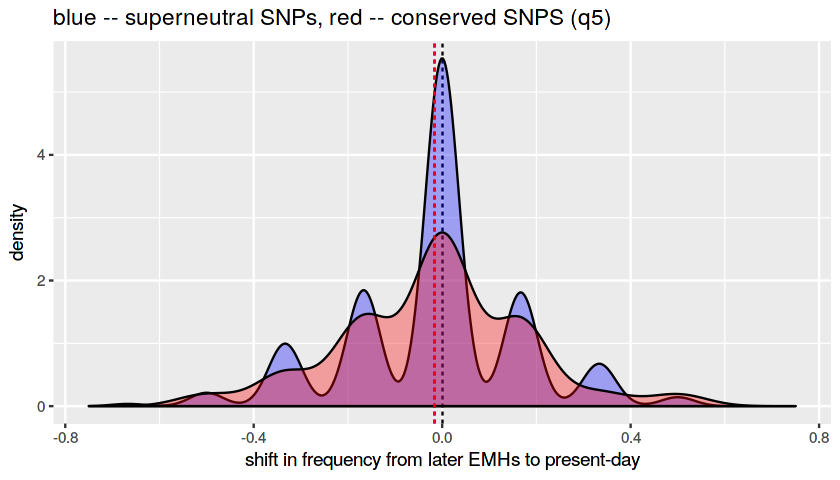

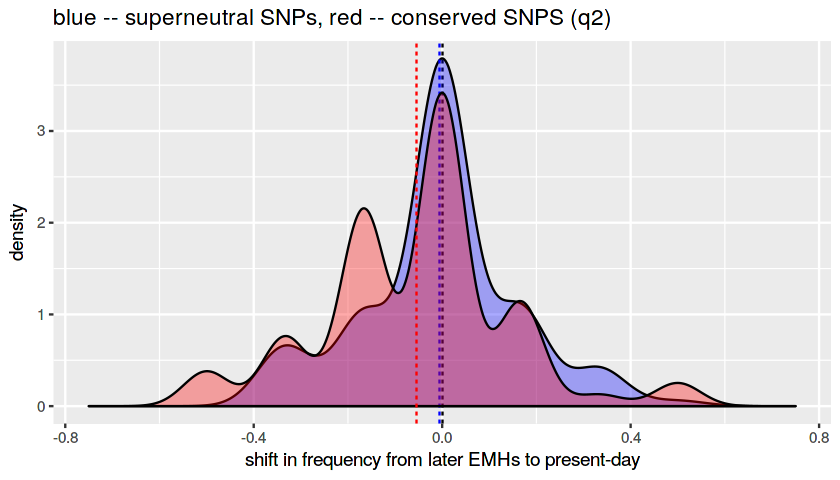

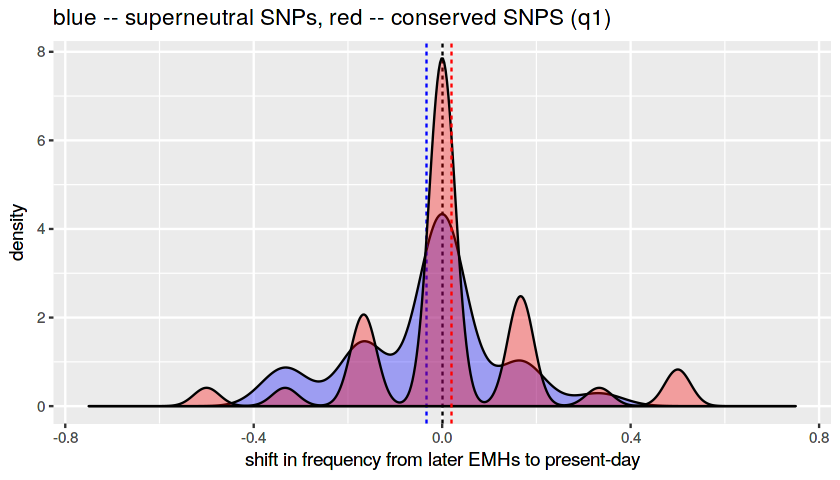

In [39]:
seg_in_emh <- filter(sfs_shift, EMH_Europe > 0, EMH_Europe < 1, present_Europe > 0, present_Europe < 1)

for (q in c("q5", "q2", "q1")) {
    print(
        ggplot() +
            geom_vline(xintercept=0, linetype=2, color="black") +

            geom_density(data=filter(seg_in_emh, priPhCons__100000bp < quantiles[[q]][1]), aes(freq_shift), alpha=1/3, fill="blue") +
            geom_vline(xintercept=mean(filter(seg_in_emh, priPhCons__100000bp < quantiles[[q]][1])$freq_shift), linetype=2, color="blue") +

            geom_density(data=filter(seg_in_emh, priPhCons__100000bp > quantiles[[q]][2]), aes(freq_shift), alpha=1/3, fill="red") +
            geom_vline(xintercept=mean(filter(seg_in_emh, priPhCons__100000bp > quantiles[[q]][2])$freq_shift), linetype=2, color="red") +

            xlab("shift in frequency from later EMHs to present-day") +
            ggtitle(paste0("blue -- superneutral SNPs, red -- conserved SNPS (", q, ")")) +
        
            xlim(-0.75, 0.75)
    )
}